In [5]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.metrics.pairwise import euclidean_distances

In [6]:
s_columns = ["rango_edad","tipo_inst_2","jornada","tipo_plan_carr","region_sede","nivel_carrera_2","requisito_ingreso", \
    "vigencia_carrera","area_conocimiento","acreditada_carr","acreditada_inst","anio_ing_carr_ori","sem_ing_carr_ori", \
    "anio_ing_carr_act","sem_ing_carr_act",\
    "dur_total_carr", \
    "valor_matricula","valor_arancel"]
# Saqué "nomb_inst", "nomb_carrera", "dur_estudio_carr","dur_proceso_tit"

path_to_2015 = "../../Data/2015.csv" # Hay que agregar el de cada uno.
df = pd.read_csv(path_to_2015) 
select = df.loc[:, s_columns]
all_dict = {}
for column in select.select_dtypes('object'):
    all_dict[column] = {value:i+1 for i, value in enumerate(select[column].unique()) if value is not np.nan}

print(all_dict)
all_dict["rango_edad"] = {'15 a 19 años':1,'20 a 24 años':2, '35 a 39 años':3, '25 a 29 años':4, '30 a 34 años':5, '40 y más años':6}
all_dict["nivel_carrera_2"] = {'Carreras Técnicas':1, 'Carreras Profesionales':2, 'Magister':3, 'Postítulo':4, 'Doctorado':5}
all_dict["acreditada_carr"] = {"NO ACREDITADA":0, "ACREDITADA":1}
all_dict["acreditada_inst"] = {"NO ACREDITADA":0, "ACREDITADA":1}

{'rango_edad': {'20 a 24 años': 1, '15 a 19 años': 2, '35 a 39 años': 3, '25 a 29 años': 4, '30 a 34 años': 5, '40 y más años': 6}, 'tipo_inst_2': {'Universidades Privadas': 1, 'Universidades CRUCH': 2, 'Institutos Profesionales': 3, 'Centros de Formación Técnica': 4}, 'jornada': {'Diurno': 1, 'Vespertino': 2, 'A Distancia': 3, 'Otro': 4, 'Semipresencial': 5}, 'tipo_plan_carr': {'Plan Regular': 1, 'Plan Regular de Continuidad': 2, 'Plan Especial': 3}, 'region_sede': {'Metropolitana': 1, 'Coquimbo': 2, 'Tarapacá': 3, 'Arica y Parinacota': 4, 'Valparaíso': 5, 'Ñuble': 6, 'Antofagasta': 7, 'Atacama': 8, 'Biobío': 9, "Lib. Gral B. O'Higgins": 10, 'La Araucanía': 11, 'Maule': 12, 'Los Lagos': 13, 'Magallanes': 14, 'Los Ríos': 15, 'Aysén': 16}, 'nivel_carrera_2': {'Carreras Profesionales': 1, 'Carreras Técnicas': 2, 'Magister': 3, 'Postítulo': 4, 'Doctorado': 5}, 'requisito_ingreso': {'Educación Media': 1, 'Licenciatura': 2, 'Título Profesional': 4, 'Técnico de Nivel Superior': 5, 'Magíster'

In [7]:
def sim_matrix(features, labels):
    useful_labels = labels >= 0

    # primero ordenamos los datos en base al cluster que pertencen
    indices = np.argsort(labels[useful_labels])
    sorted_features = features[useful_labels][indices]

    # calculamos las distancias entre todos los puntos
    d = euclidean_distances(sorted_features, sorted_features)
    return d
    
def plotproxi(data, model):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,5))

    fig.suptitle(f"{model.__class__.__name__}")

    ax1.scatter(data[:,0], data[:,1], c=model.labels_)

    dist = sim_matrix(data, model.labels_)
    im = ax2.imshow(dist, cmap="jet")
    fig.colorbar(im, ax=ax2)

# Podemos seleccionar un atributo, y ordenar los clusters de acuerdo
# a la cantidad de cierta caracteristica en el atributo.
def right_tag(df, model,  n_clusters, col="area_conocimiento", value="Ciencias Básicas"):
    indx = all_dict[col][value]
    quantities = np.zeros(n_clusters)
    for cluster in range(n_clusters):
        count = df.loc[model.labels_==cluster,:][col].value_counts()
        try: val = count.loc[indx]
        except: val = 0
        quantities[cluster] = val
    neworder = np.argsort(quantities)
    model.labels_ = np.array([neworder[label] for label in model.labels_])
    #return 

n° de instancias:  10000
Inercia del año 2010 42246.498141404394


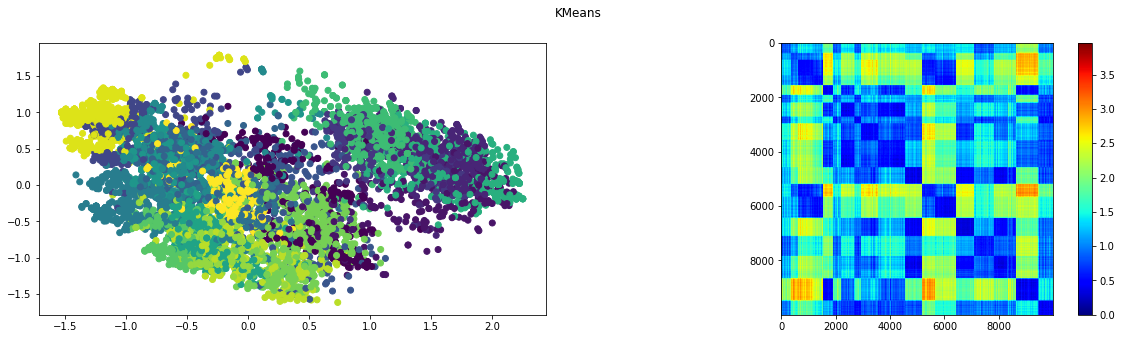

d:\Proyectos\Python_proyects\Algos-y-Estructuras\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


n° de instancias usadas:  10000
Silhouete del espacio PCA con KMeans Clustering	 -0.011323790682246496
Silhouette del espacio one-hot con KMeans Clustering	 0.07710562796231614

n° de instancias:  10000
Inercia del año 2011 43078.168729594174


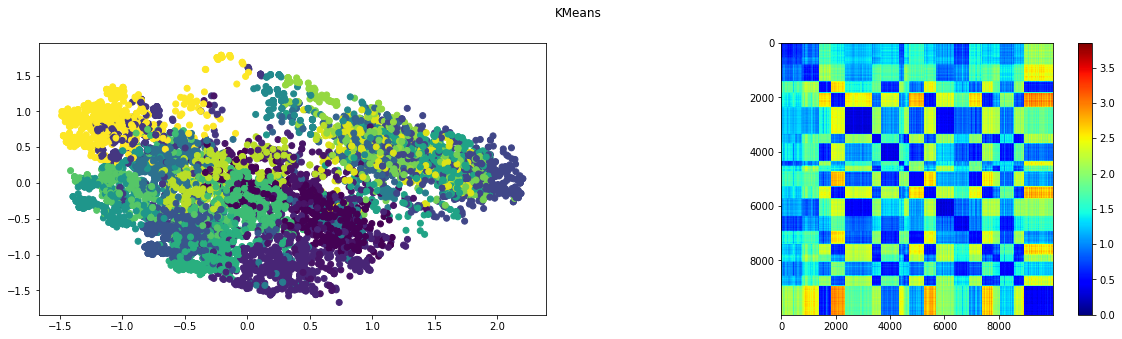

d:\Proyectos\Python_proyects\Algos-y-Estructuras\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


n° de instancias usadas:  10000
Silhouete del espacio PCA con KMeans Clustering	 0.035365353341361205
Silhouette del espacio one-hot con KMeans Clustering	 0.08149195910951157

n° de instancias:  10000
Inercia del año 2012 43119.22658732171


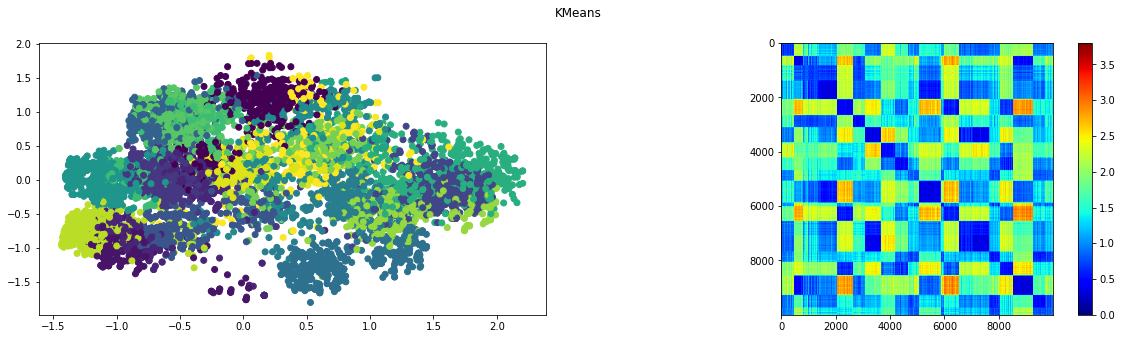

d:\Proyectos\Python_proyects\Algos-y-Estructuras\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


n° de instancias usadas:  10000
Silhouete del espacio PCA con KMeans Clustering	 0.044159060968920916
Silhouette del espacio one-hot con KMeans Clustering	 0.0806740615210053

n° de instancias:  10000
Inercia del año 2013 41298.96020343526


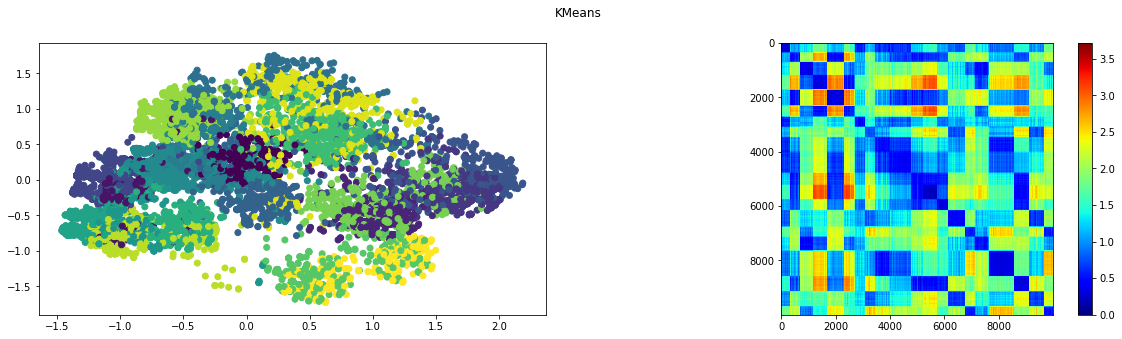

d:\Proyectos\Python_proyects\Algos-y-Estructuras\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


n° de instancias usadas:  10000
Silhouete del espacio PCA con KMeans Clustering	 0.08423410575319476
Silhouette del espacio one-hot con KMeans Clustering	 0.07936110574473496

n° de instancias:  10000
Inercia del año 2014 42392.22268764166


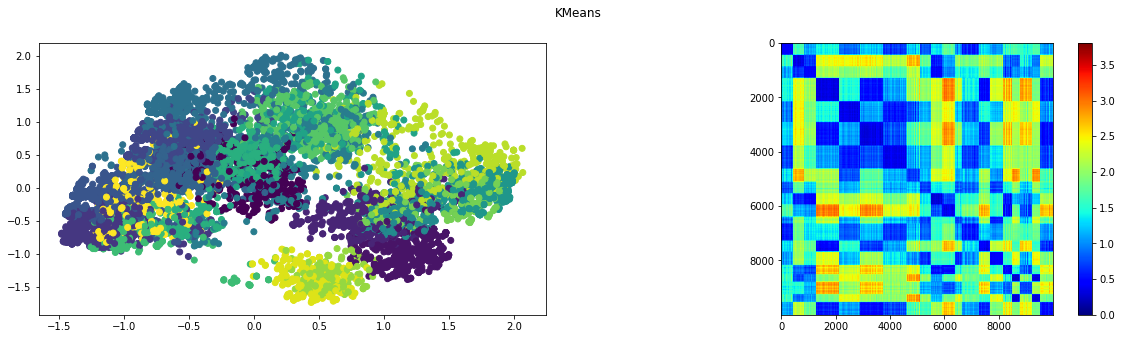

d:\Proyectos\Python_proyects\Algos-y-Estructuras\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


n° de instancias usadas:  10000
Silhouete del espacio PCA con KMeans Clustering	 0.050775579927532906
Silhouette del espacio one-hot con KMeans Clustering	 0.07704071635341186

n° de instancias:  10000
Inercia del año 2015 42817.43236871694


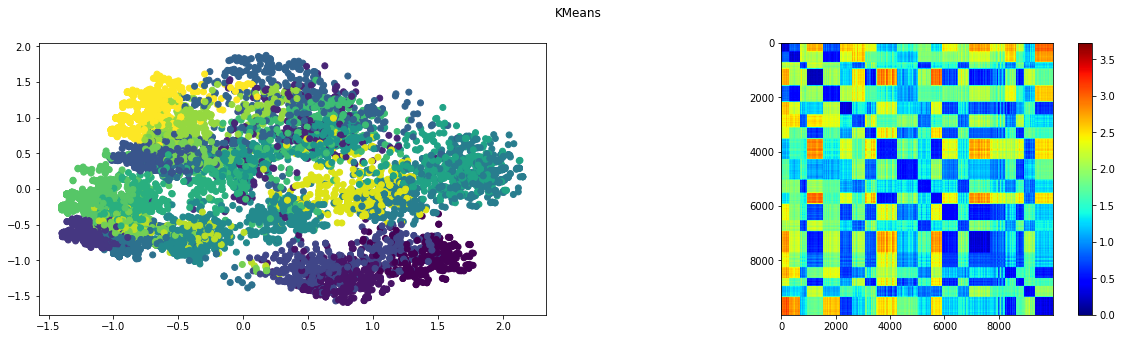

d:\Proyectos\Python_proyects\Algos-y-Estructuras\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


n° de instancias usadas:  10000
Silhouete del espacio PCA con KMeans Clustering	 0.07308641876983377
Silhouette del espacio one-hot con KMeans Clustering	 0.08014256687992136

n° de instancias:  10000
Inercia del año 2016 41218.06522582609


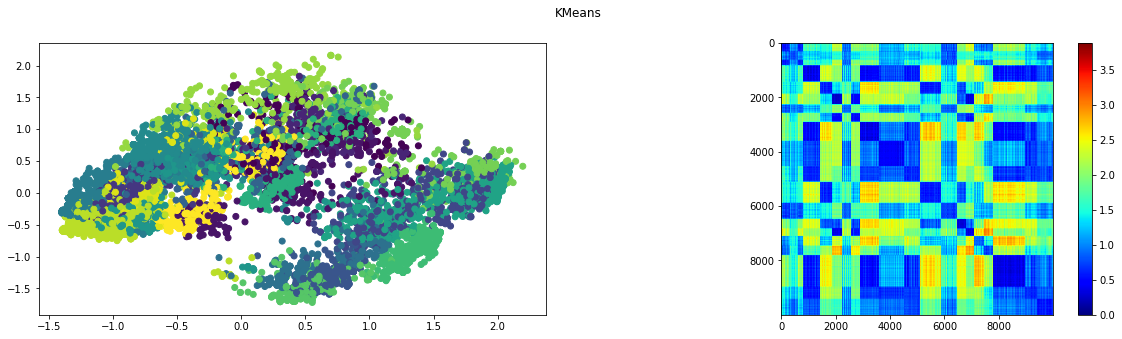

d:\Proyectos\Python_proyects\Algos-y-Estructuras\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


n° de instancias usadas:  10000
Silhouete del espacio PCA con KMeans Clustering	 -0.00046020981600127317
Silhouette del espacio one-hot con KMeans Clustering	 0.08098741960026677



d:\Proyectos\Python_proyects\Algos-y-Estructuras\lib\site-packages\IPython\core\interactiveshell.py:3441: DtypeWarning: Columns (45) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


n° de instancias:  10000
Inercia del año 2017 41649.550520311226


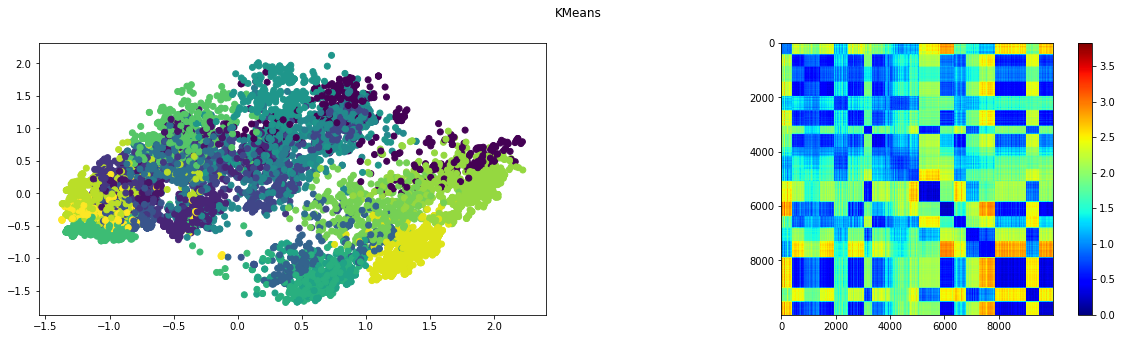

d:\Proyectos\Python_proyects\Algos-y-Estructuras\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


n° de instancias usadas:  10000
Silhouete del espacio PCA con KMeans Clustering	 0.008490222622809905
Silhouette del espacio one-hot con KMeans Clustering	 0.07749189237783793

n° de instancias:  10000
Inercia del año 2018 43601.991838357164


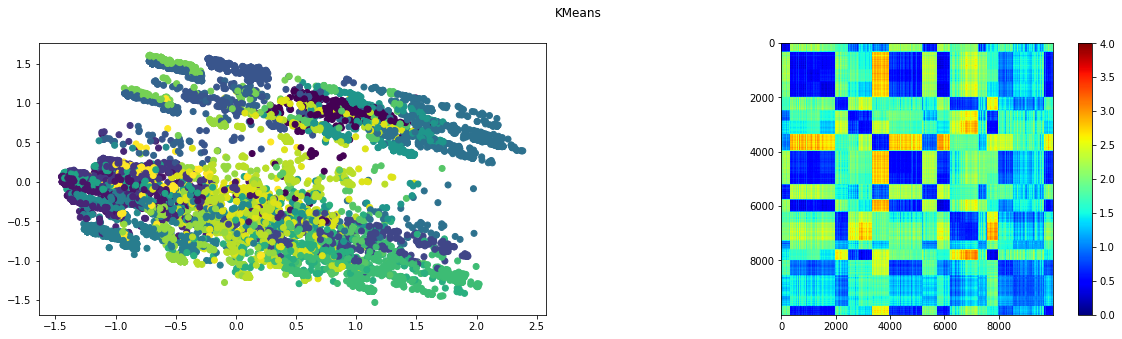

d:\Proyectos\Python_proyects\Algos-y-Estructuras\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


n° de instancias usadas:  10000
Silhouete del espacio PCA con KMeans Clustering	 -0.07704703366904166
Silhouette del espacio one-hot con KMeans Clustering	 0.09472686254693201

n° de instancias:  10000
Inercia del año 2019 43153.76550594182


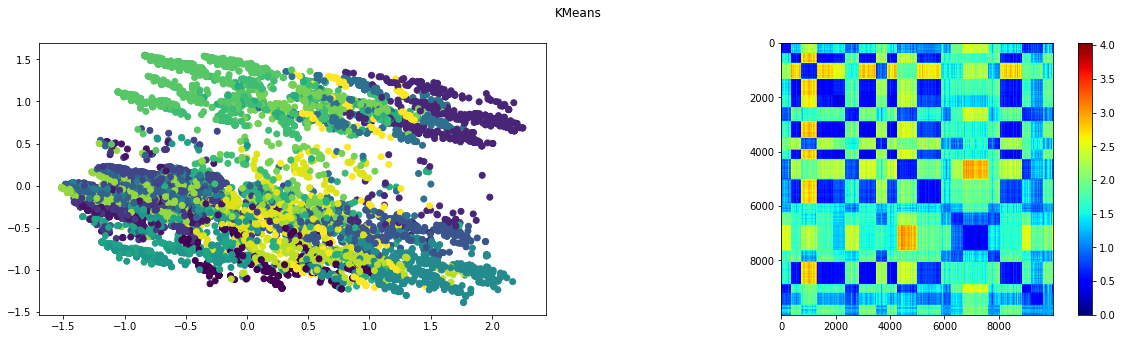

d:\Proyectos\Python_proyects\Algos-y-Estructuras\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


n° de instancias usadas:  10000
Silhouete del espacio PCA con KMeans Clustering	 -0.02209234339492895
Silhouette del espacio one-hot con KMeans Clustering	 0.10539461166032484

[-0.56090586  0.46647537  0.05576004 -0.54490937  1.34206879  1.44822652
 -0.53417596  1.17881153 -0.94789353]


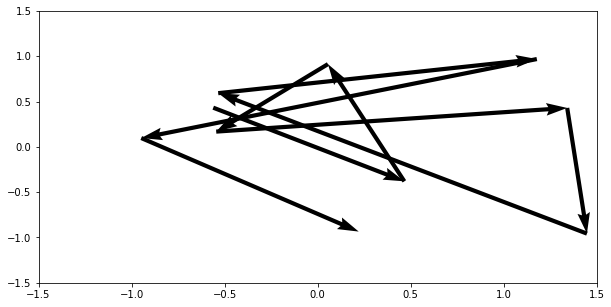

[ 1.02784349 -0.2554861  -1.1744544  -0.58741846 -1.18457996 -0.71092762
 -1.06039626 -1.05165799  0.08673461]


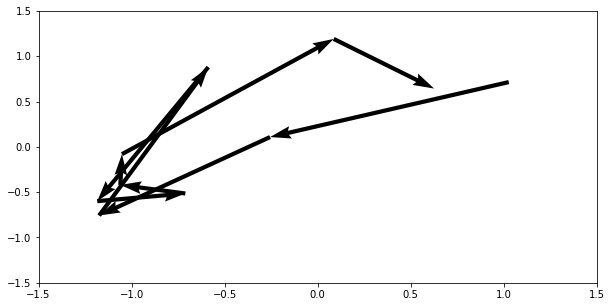

[-0.370144   -0.32640219  1.3105458   1.06899868 -0.58819336 -1.19222709
  0.520412    0.68806613  1.71537313]


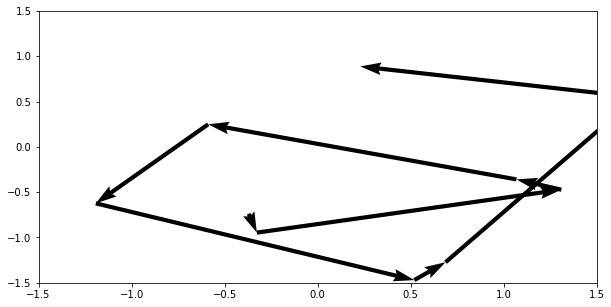

[ 0.26482013  1.49035943  1.56763463  0.7385264  -0.29904413 -1.14625457
  0.36842732  0.00611291 -0.34365519]


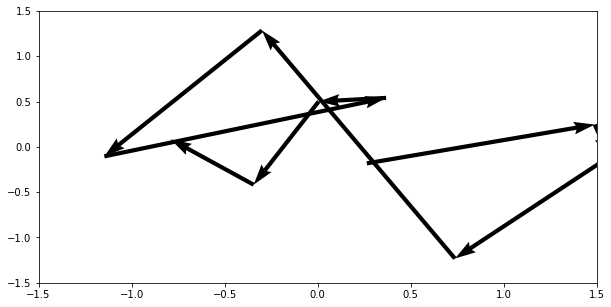

[-0.2084564  -0.6529721  -0.38165999 -1.28123852  1.43566252 -0.72186626
  1.45683682 -1.04053125 -1.06239265]


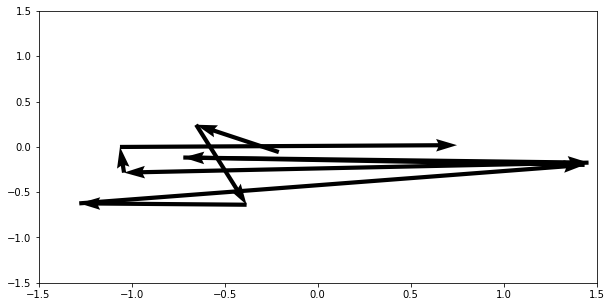

[ 1.09682865  1.12846722 -0.664198    0.03100433  1.71587925  1.52195892
 -0.65934226 -0.83503779  0.3108575 ]


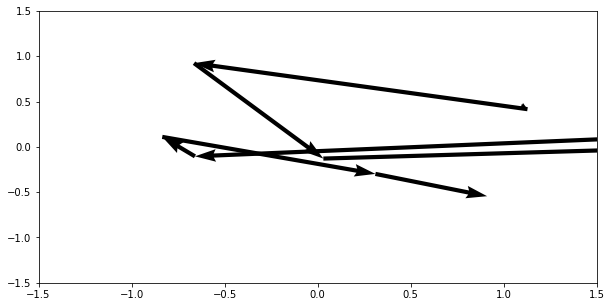

[-0.93881656  0.88156266  0.45285839  0.88158728 -0.15074792  0.8830816
  0.67461189 -0.7188154  -0.46876888]


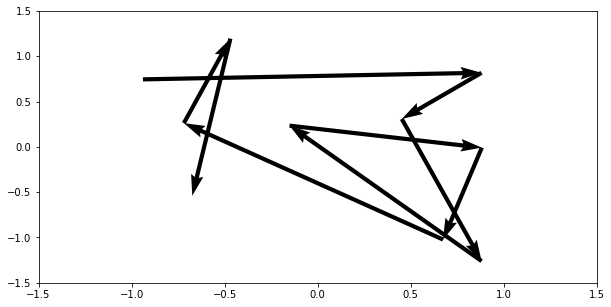

[-0.90538883 -0.87586343 -0.48867238  1.69666577  0.51531942 -0.34652832
 -0.25995933  1.72042226  1.08698175]


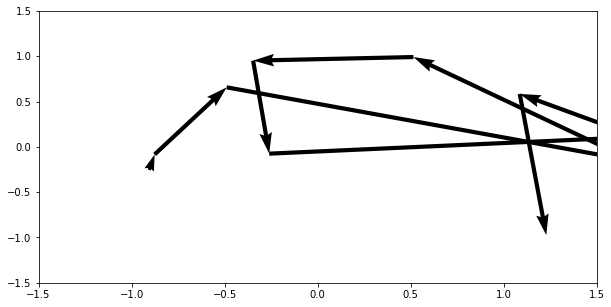

[-0.62370071 -0.57065819  1.56292595  1.62835078 -0.88999329  0.73385602
 -0.88801329 -0.24962205 -0.95880709]


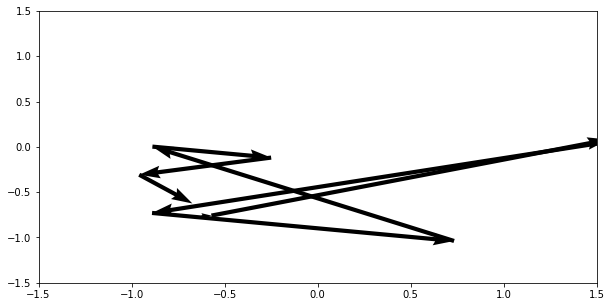

[ 0.07178743 -1.13807864  0.83937124 -0.539472   -0.60403183 -0.68472463
  0.47633875  1.10887518 -0.81980939]


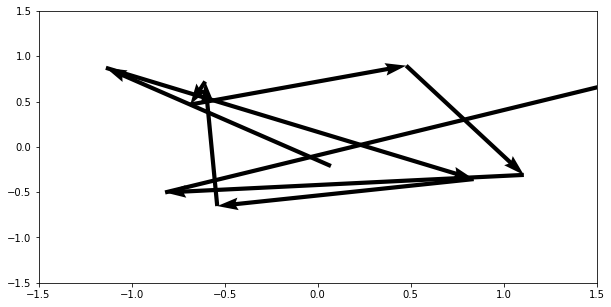

[-1.20515172  0.94958959 -0.61835923 -0.35078432  0.43390934 -0.7392483
  0.102703   -0.50788219  1.03355117]


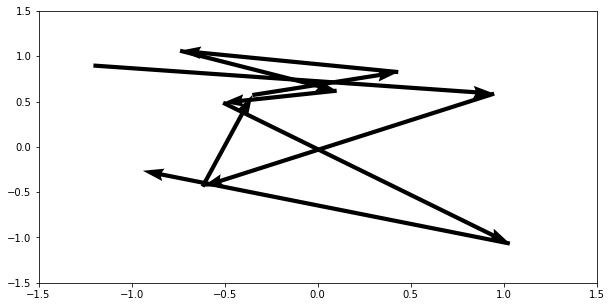

[ 1.33045322  0.86180341  0.46511153  0.40828089 -1.14667429  1.60083577
 -1.16157997  0.66875221  0.79121097]


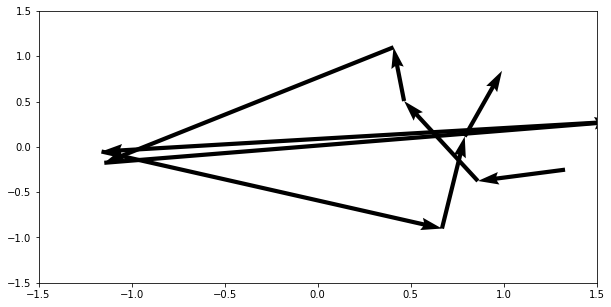

[ 1.51209256 -0.03157845  0.81154706  0.53323968 -0.9224241   0.41388736
  1.25889658 -0.45173935 -0.71926769]


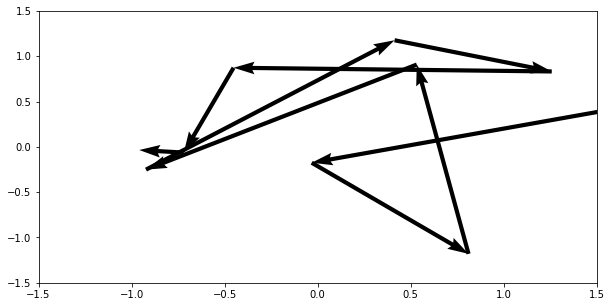

[-0.07619727 -1.03567636  0.16648358  1.05000175  0.44955145 -0.6730639
  1.38976231 -0.73795857  0.86967843]


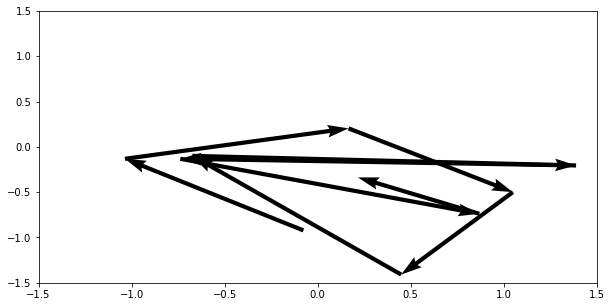

[ 1.64221478  1.35365691 -0.63511337 -1.13641715  0.58523368  0.37128293
  1.31590222  0.50461268  0.62010713]


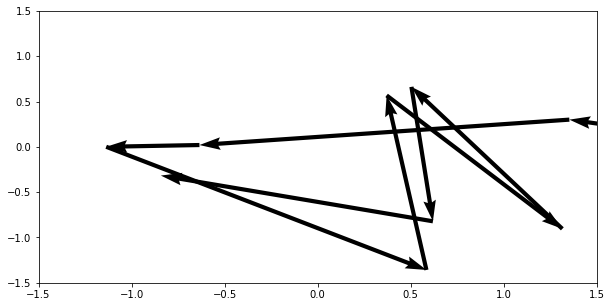

[-0.61389698 -0.85129377  0.90277892  0.59689238 -0.03325424 -0.73361395
  0.1274044   1.3475956  -0.49920625]


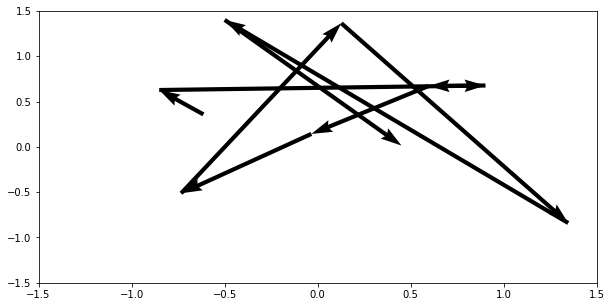

[-0.68778427  0.37656518  0.48074717 -0.94055817  0.36551287  0.40896015
 -0.6803498   0.61103224  0.84665762]


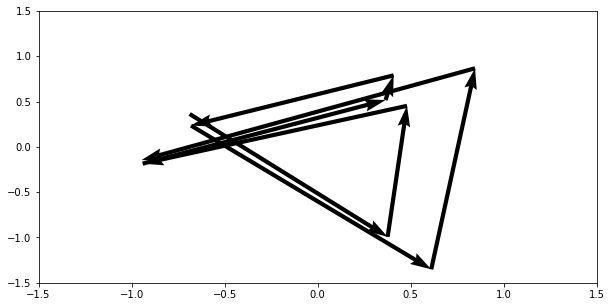

[-0.31360424  0.59705651 -1.09166133 -0.93124307  1.17954102  0.76774312
  0.67159362  0.39430056  0.42779949]


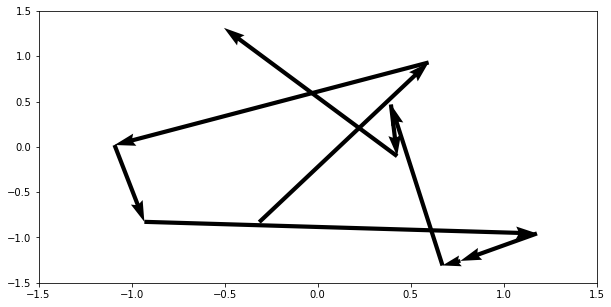

[ 0.48789989  0.43645006 -0.92581466 -0.91617383  1.12767093 -0.15042618
  0.32155491 -1.06906747 -0.85525541]


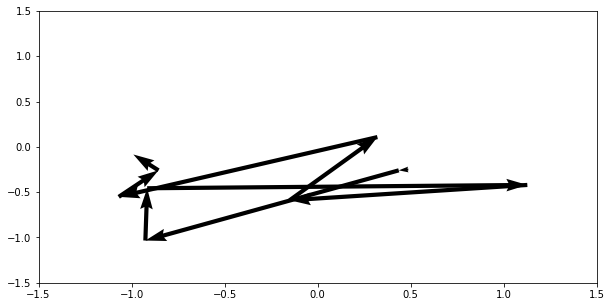

[ 0.41344111  1.65304226 -0.52865946 -0.02965453  0.88813868  0.48599892
  0.49592602  0.32615326 -1.02213416]


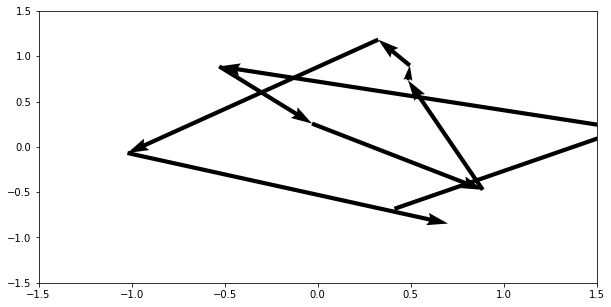

In [8]:
used = 10000
n_clus = 20 # Ideal: 20
np.random.seed(10)
n_years = 10
ndims = 2

select_columns = s_columns.copy()
for nn in ['requisito_ingreso', 'vigencia_carrera']:
    try: select_columns.remove(nn)
    except: pass
    try: all_dict.pop(nn)
    except: pass

macro_varancel = np.zeros(n_years)
macro_vmatricula = np.zeros(n_years)
macro_areaconocimiento = np.zeros(n_years, dtype='object')
macro_acredcarr = np.zeros(n_years, dtype='object')

centroid_coord = np.zeros((n_years, n_clus, ndims))
for i in range(n_years):
    path = f"../../Data/201{i}.csv" # Hay que agregar el de cada uno.
    df = pd.read_csv(path, nrows=None)
    sample = np.random.choice(len(df), used)

    macro_varancel[i] = df["valor_arancel"].mean()
    macro_vmatricula[i] = df["valor_matricula"].mean()
    macro_acredcarr[i] = df["acreditada_carr"].value_counts().index[0]
    macro_areaconocimiento[i] = df["area_conocimiento"].value_counts().index[0]
    
    #Se escoger al azar 'used' número de instancias.
    df = df.loc[sample, select_columns]
    for attribute in all_dict:
        df[attribute] = df[attribute].map(all_dict[attribute])
    df.iloc[:,:-2] = df.iloc[:,:-2].convert_dtypes(np.int32)
    dumm = pd.get_dummies(df, prefix=select_columns[:-2], columns=select_columns[:-2])

    print("n° de instancias: ", len(df))
    
    kmean = KMeans(n_clusters=n_clus).fit(dumm.iloc[:,2:])
    print(f"Inercia del año 201{i}", kmean.inertia_)
    right_tag(df,kmean,n_clus) # Nuevas labels por contenido.

    pca = PCA(n_components=ndims, random_state=1).fit(dumm.iloc[:,2:])
    new_space = pca.transform(dumm.iloc[:,2:])
    plotproxi(new_space, kmean)
    plt.show()
    centroid_coord[i, :, :] = pca.transform(kmean.cluster_centers_)
    
    print("n° de instancias usadas: ", used)
    print("Silhouete del espacio PCA con KMeans Clustering\t", silhouette_score(new_space, kmean.labels_))
    print("Silhouette del espacio one-hot con KMeans Clustering\t", silhouette_score(dumm.iloc[:,2:], kmean.labels_))
    print()

for centroid in range(n_clus):
    a = centroid_coord[:-1,centroid,:]
    print(a[:,0])
    b = centroid_coord[1:,centroid,:]
    fig, ax = plt.subplots(1, 1, figsize=(10,5))
    ax.set_xlim(-1.5,1.5)
    ax.set_ylim(-1.5,1.5)
    ax.quiver(a[:,0], a[:,1], b[:,0]-a[:,0], b[:,1]-a[:,1], scale_units='xy', angles='xy', scale=1)
    plt.show()
